# Introducción
    El siguiente trabajo consta de un estudio de análisis de elasticidad demanda-precio en contexto inflacionario de las ventas de distribuidores del sector consumo masivo en formato B2B, para lograr estimar mediante un modelo de machine learning la demanda que se consiguiera al realizar un aumento de precio en tal contexto.

### Objetivo
    El objetivo de este trabajo es realizar un modelo que pueda estimar la variación de demanda que sufrirá una empresa al subir o bajar precios en un contexto inflacionario.

In [2]:
#Importo librerías
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

In [3]:
#Función para mostrar valores en formato $
def formato_dolar_simple(valor):
    return f'${valor:.0f}'

#Función para mostrar valores en formato miles
def formato_miles_simple(valor):
    return "{:,.0f}".format(int(valor)).replace(",", "@").replace(".", ",").replace("@", ".")

#Función para mostrar valores en formato $
def formato_dolar_etiqueta(valor, _):
    return f'${valor:.0f}'

#Función para mostrar valores en formato miles
def formato_miles_etiqueta(valor, _):
    return "{:,.0f}".format(int(valor)).replace(",", "@").replace(".", ",").replace("@", ".")

In [4]:
#Parámetros de gráficos
sns.set(style="ticks", font_scale=1, rc={"font.family": "Segoe UI"})

In [5]:
#cargo dataset
url = "https://github.com/Hart-Hunt/Coderhouse---Data-Science/raw/main/Base%20Ventas%20Retail%20v3.xlsx"
dataset_orig = pd.read_excel(url)

In [6]:
df = dataset_orig

### Dataset:
    El dataset planteado contiene información de ventas de distribuidores del sector de consumo masivo operando en la región de Gran Buenos Aires.
    Los datos se presentan a nivel de granularidad producto-cliente, agrupados por semana.
###### Anonimización:
    Por cuestiones de confidencialidad, los campos descriptivos de tanto los productos como los clientes fueron anonimizados previo al comienzo de este análisis mediante seudonimización. Campos tales como localidad, partido, canal no fueron alterados del dataset original.

# Exploratory Data Analysis (EDA)

### Limpieza del dataset
    Comenzamos a detallar y analizar el dataset.

In [7]:
#Viendo la cantidad de campos y registros
df.shape

(102457, 15)

    El dataset contiene una gran cantidad de registros y campos. Veamos los campos con una pequeña muestra.

In [156]:
df.sample(5)

,Semana,Semana (Lunes),Tiene Feriado,Producto,Marca,Tipo Packaging,KG / U,U / Pack,Cliente,Canal,Localidad,Partido,KG,Precio Neto,Precio Neto Deflactado
16168,Semana 06 de 2023,2023-01-30,NO,Flavori x4,Flavori,Tipo 1,0.069,4,Cliente 7620440,Autoservicio,González Catán,La Matanza,19.872000,1123.587778,1053.748275
38650,Semana 18 de 2023,2023-04-24,NO,Bistro x4,Bistro,Tipo 1,0.069,4,Cliente 6089728,Autoservicio,González Catán,La Matanza,13.441217,980.545369,744.834739
16761,Semana 07 de 2023,2023-02-06,NO,Bistro x4,Bistro,Tipo 1,0.069,4,Cliente 1038322,Kiosco,Moreno,Moreno,6.720609,911.111032,838.826638
83117,Semana 43 de 2023,2023-10-16,SI,Munchie x4,Munchie,Tipo 1,0.080,4,Cliente 8484579,Almacén,Merlo,Merlo,7.920248,2672.621170,1212.629817
30517,Semana 13 de 2023,2023-03-20,SI,Flavori x4,Flavori,Tipo 1,0.069,4,Cliente 8773053,Autoservicio,Villa Madero,La Matanza,3.312000,1398.256190,1160.317220


###### Se detallan los campos:
    
    Semana, Semana (Lunes): Semana correspondiente al registro.
    Tiene Feriado: Campo con valor SI para las semanas que tuvieron como mínimo un feriado nacional.

    Producto: Descripción del producto (anonimizado).
    Marca: Marca del producto (anonimizado).
    Tipo Packaging: Tipo de packaging del producto.
    KG / U: Peso en KG por unidad de producto dentro del pack.
    U / Pack: Unidades de producto por cada pack.
    
    Cliente: Nombre del cliente (llamado por su número de cliente).
    Localidad: Donde reside el ciente.
    Partido: Agrupador de Localidad.
    Canal: Tipo de cliente según clasificación tipo en sector consumo masivo.
    
    KG: Venta en cantidades medida en KGs.
    Precio: Precio de venta neto sin IVA, medido en pesos argentinos / KG.
    Precio Deflactado: Campo Precio, dividido por valor del Índice de Precios de Consumidor General Nacional [Fuente: INDEC], intrapolado semanalmente (mismo % de variación en cada semana por mes).

    El dataset por lo tanto tiene las ventas realizadas por empresas distribuidoras en formato B2B (Business To Business), de productos del sector consumo masivo.
    La venta se encuentra cerrada por semana, y al ser de Argentina del año 2023 se deberían observar comportamientos inflacionarios de precio.

    Para esto sin embargo debemos avanzar en la limpieza del dataset, para un correcto estudio del mismo.

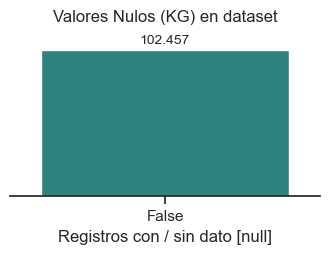

In [9]:
# Chequeamos registros nulos

nulos = pd.isnull(df['KG']).value_counts()

#Cambiar tamaño al gráfico
plt.figure(figsize=(4,2))

# Configurar el estilo para quitar los bordes
sns.set(style="ticks", rc={"axes.spines.bottom": True, "axes.spines.top": False, 
                           "axes.spines.right": False, "axes.spines.left": False})

# Crear un gráfico de barras con Seaborn
ax = sns.barplot(x=nulos.index, y=nulos.values, palette='viridis')

# Quitar los marcadores del eje y
ax.yaxis.set_visible(False)

# Agregar etiquetas a los datos
for index, value in enumerate(nulos.values[::-1]):
    ax.text(index, value * 1.02, formato_miles_simple(value), ha='center', va='bottom', fontsize=10)

# # Ajustar el espacio entre el título y el gráfico
# plt.subplots_adjust(top=0.8)    
    
# Añadir etiquetas y título
plt.xlabel('Registros con / sin dato [null]')
plt.title('Valores Nulos (KG) en dataset', pad=15)

# Mostrar el gráfico
plt.show()
# print(f"Porcentaje de Nulos: {100 * nulos.loc[True] / (nulos.loc[True] + nulos.loc[False]):.0f}%")

    El dataset como se observa, no contiene datos nulos de KG.

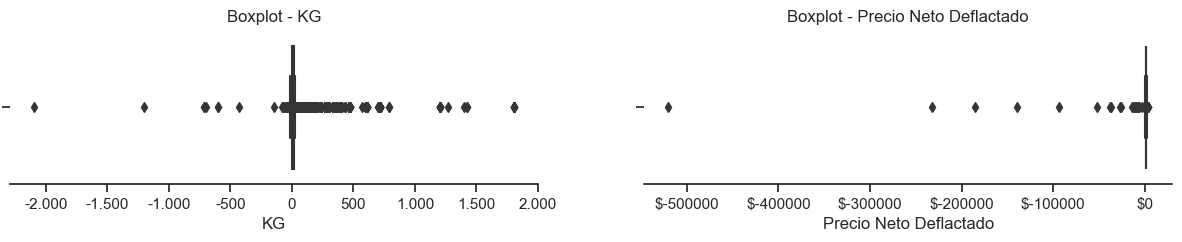

In [136]:
# Crear una figura y ejes compartidos
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 2))

# Boxplot para Campo1
sns.boxplot(x=df['KG'], ax=axs[0], palette = 'viridis')
axs[0].set_title('Boxplot - KG')
axs[0].xaxis.set_major_formatter(FuncFormatter(formato_miles_etiqueta))

# Boxplot para Campo2
sns.boxplot(x=df['Precio Neto Deflactado'], ax=axs[1], palette = 'viridis')
axs[1].set_title('Boxplot - Precio Neto Deflactado')
axs[1].xaxis.set_major_formatter(FuncFormatter(formato_dolar_etiqueta))

# Mostrar la figura
plt.show()


In [11]:
print(" Cantidad de registros con Precio Neto <= 1: ",df[df['Precio Neto']<=1]['Precio Neto'].size, "\n",
      "Cantidad de registros con KG <= 0: ",df[df['KG']<=0]['KG'].size, "\n",
      "Cantidad de registros con (KG <= 0, o Precio Neto <= 1): ",df[(df['KG'] <= 0) | (df['Precio Neto'] <= 1)]['KG'].size, "\n",
      "Porcentaje de registros a quitar sobre total: {:.1f}%".format(100*df[(df['KG'] <= 0) | (df['Precio Neto'] <= 1)]['KG'].size / df.KG.size)
     )

 Cantidad de registros con Precio Neto <= 1:  51 
 Cantidad de registros con KG <= 0:  3345 
 Cantidad de registros con (KG <= 0, o Precio Neto <= 1):  3381 
 Porcentaje de registros a quitar sobre total: 3.3%


    Por otro lado sí se observan valores negativos y 0, tanto en KG como en Precio.

    Se nos informó que el dataset podía contener tales casos, los cuales de ocurrir son errores de medición de la muestra. 
    Dentro de los mismos, tenemos los siguientes casos:
        KG < 0 & Precio Neto = 0: Error en la variable, no hubo venta.
        KG < 0 & Precio Neto < 0: Error en la variable, Importe Neto devuelto sin venta involucrada.
        KG < 0 & 0 < Precio Neto < 1: Error en la variable, importes varios devueltos al cliente.
        KG < 0 & Precio Neto > 0: Devolución del producto, se registra como KG vendidos negativos con Precio Neto positivo.
        
    Nuestro objetivo es medir la variabilidad de volumen al modificar el precio, lo cual no es posible matemáticamente calcular con datos con Precio Neto <= 0. Tomamos como assumption una muestra de los datos que no considera los valores de KG < 0, o Precio < 1. Los registros quitados del estudio representan el 3,3% del total de la muestra.

In [12]:
#Quitamos valores negativos o 0 en KG o en Precio
df2 = df[(df['KG'] > 0) & (df['Precio Neto'] > 1)]

C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


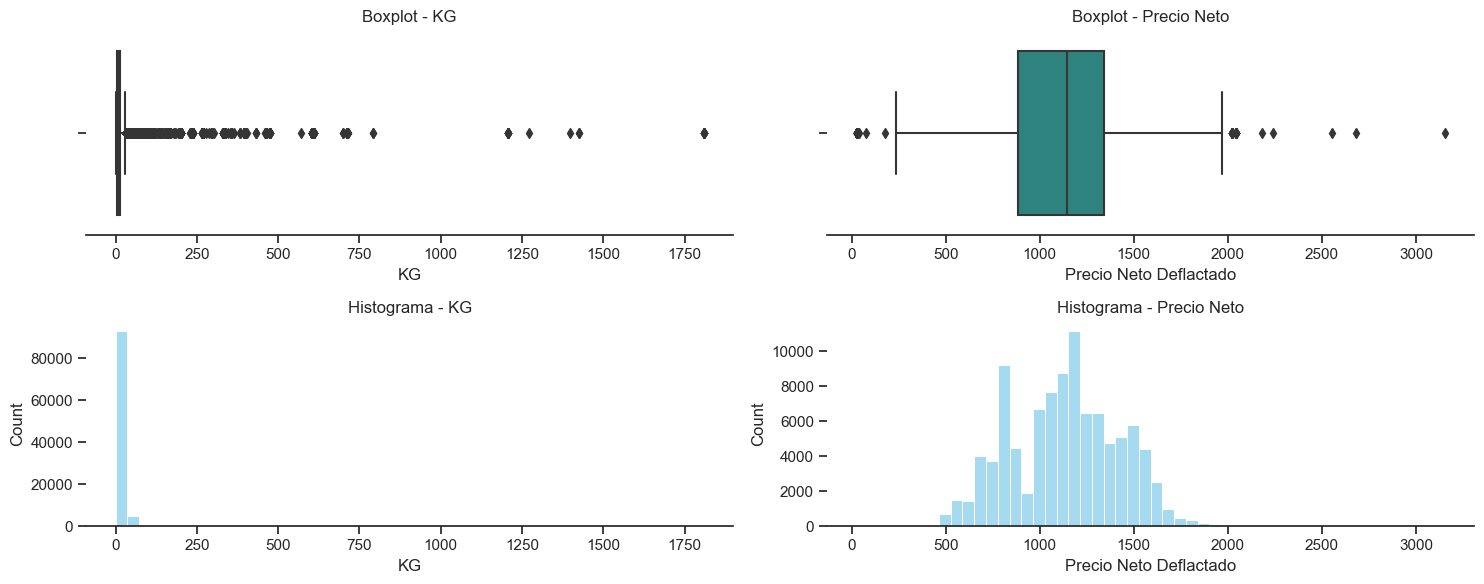

In [138]:
# Crear una figura y ejes compartidos
fig, axs = plt.subplots(2, 2, figsize=(15, 6))

# Boxplot para Campo1
sns.boxplot(x=df2['KG'], ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title('Boxplot - KG')

# Boxplot para Campo2
sns.boxplot(x=df2['Precio Neto Deflactado'], ax=axs[0, 1], palette='viridis')
axs[0, 1].set_title('Boxplot - Precio Neto')

# Histograma para Campo1
sns.histplot(x=df2['KG'], ax=axs[1, 0], color='skyblue', bins = 50)
axs[1, 0].set_title('Histograma - KG')

# Histograma para Campo2
sns.histplot(x=df2['Precio Neto Deflactado'], ax=axs[1, 1], color='skyblue', bins = 50)
axs[1, 1].set_title('Histograma - Precio Neto')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

    Desde el lado de la variable Precio, se lograron eliminar outliers mediante el último método. Sin embargo, el boxplot arriba muestra que se siguen observando otros outliers que deberán ser analizados mediante otras técnicas.
    La variable KG por otro lado, si bien también mejoró, presenta una alta cantidad de outliers, lo cual requiere de un mayor análisis.
     Ambas variables, KG y Precio Neto, deberían de comportarse de manera distinta dependiendo :
         1. El Canal de ventas al cual se realizó la venta. Por ejemplo, canales como Kioscos deberían de mostrar valores distintos a Mayoristas.
         2. Para el caso del Precio Neto, debería de comportarse distinto según la semana que se realizó la venta. Más aún, el Precio Neto deflactado debería de no mostrar la misma tendencia.

    Graficamos un histograma de variable KG por Canal para analizar el primer punto:

C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

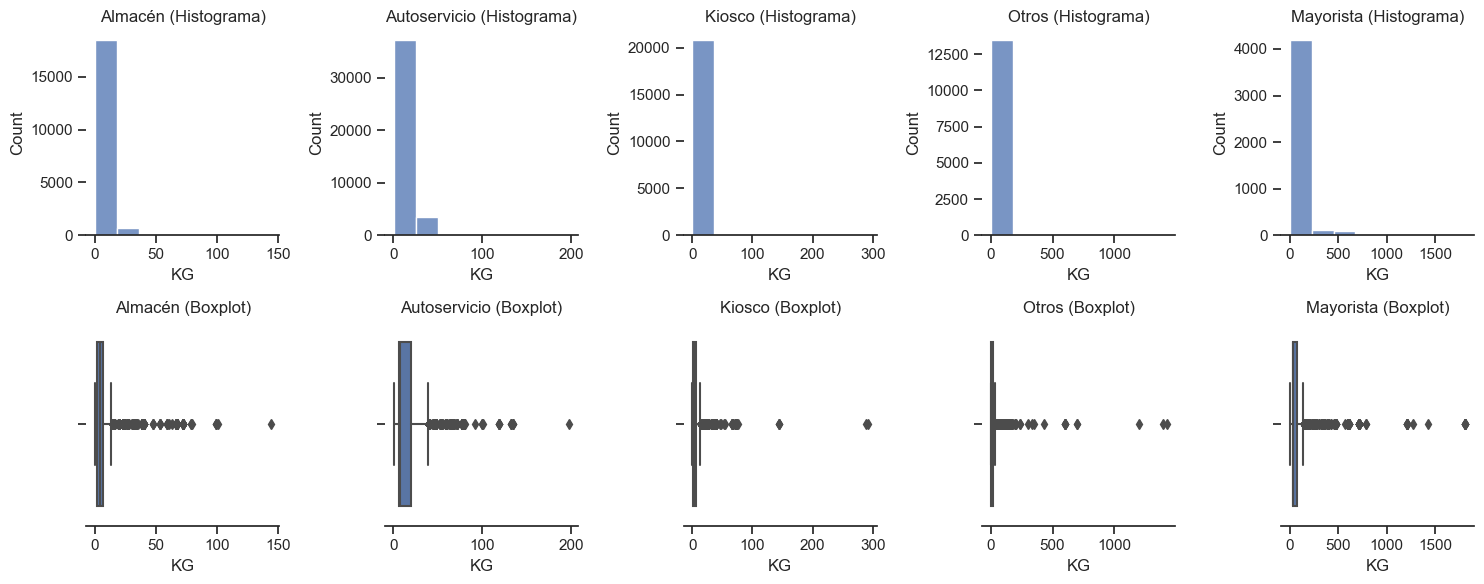

In [148]:
# Crear una figura y ejes con 2 filas y 5 columnas
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=False)

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# Generar histogramas por canal
for i, canal in enumerate(df2['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df2[df2['Canal'] == canal]
    
    # Generar histograma para el canal actual
    sns.histplot(data=datos_canal, x="KG", ax=axs[i], bins=8)  # Ajusta bins según tus necesidades
    axs[i].set_title(f'{canal} (Histograma)')

# Generar 5 boxplots adicionales
for i, canal in enumerate(df2['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df2[df2['Canal'] == canal]
    
    # Generar boxplot para el canal actual
    sns.boxplot(data=datos_canal, x="KG", ax=axs[i + 5])
    axs[i + 5].set_title(f'{canal} (Boxplot)')    
    
# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

    El histograma muestra que existe una distribución asimétrica a la derecha, con una cola derecha más larga.
    Los histogramas más los boxplot nos muestran que el Canal es un buen segregador de los datos, para identificar los outliers del campo KG.
    Hacemos el mismo ejercicio con las variables Precio Neto y Precio Neto Deflactado.

C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

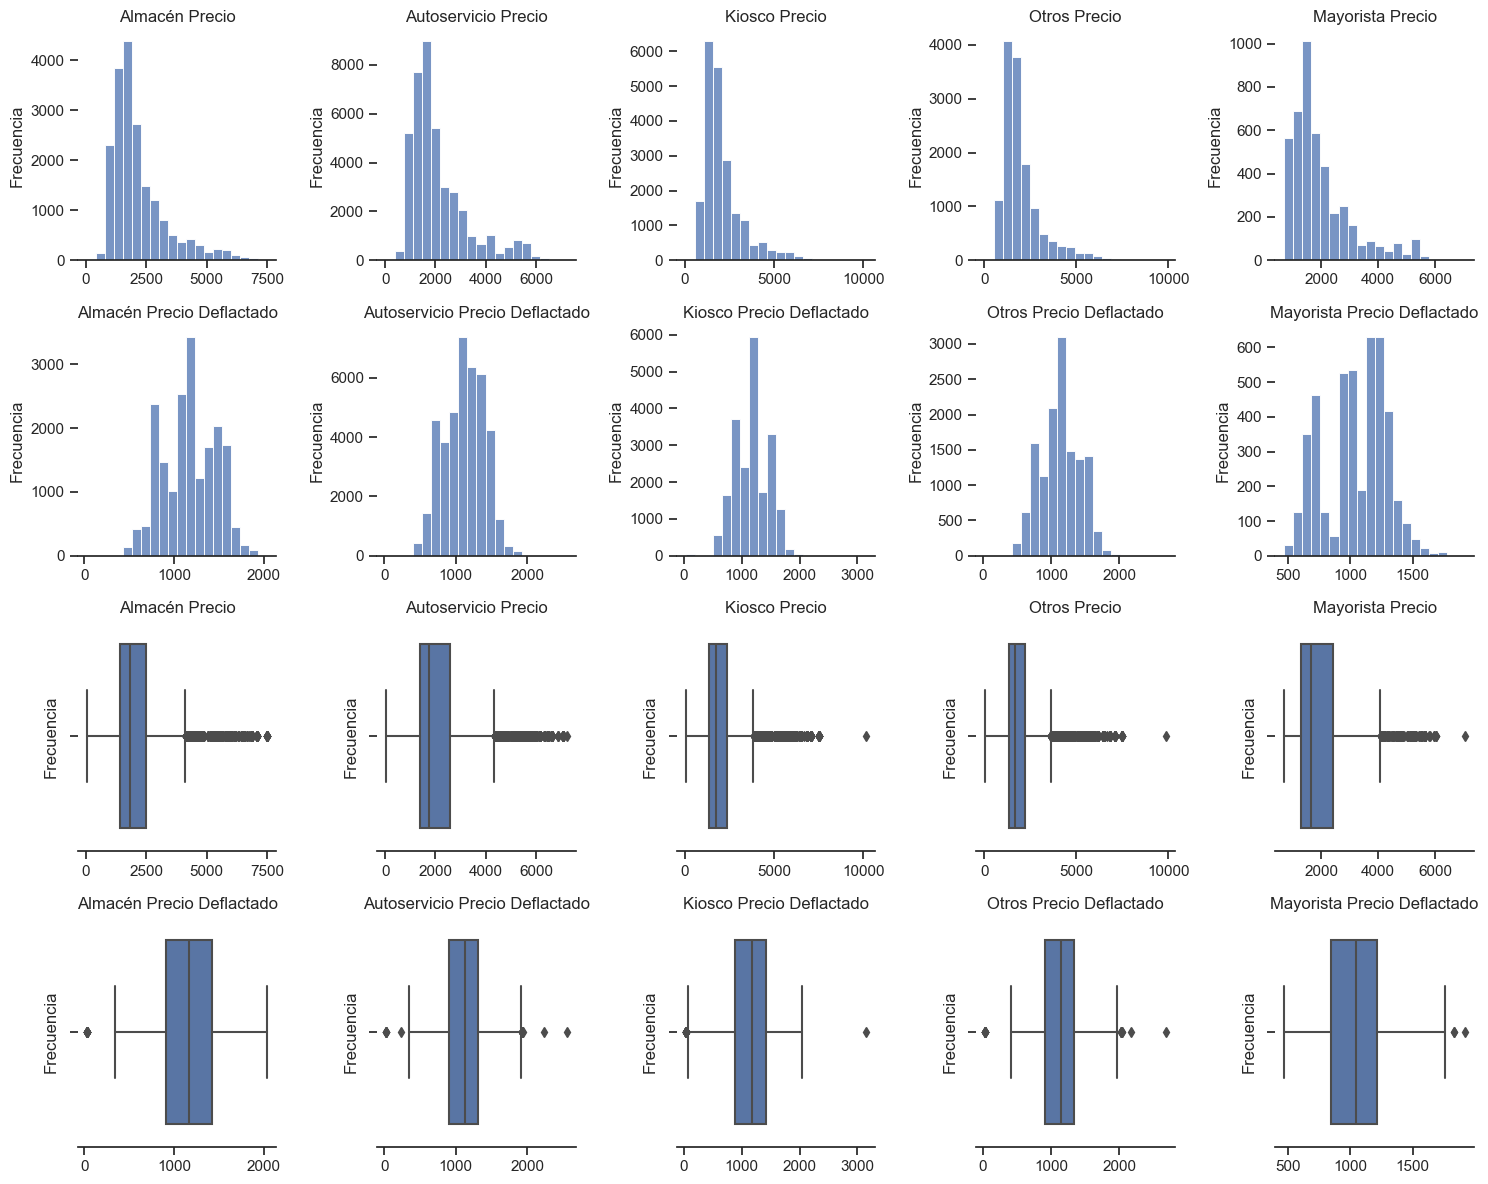

In [143]:
# Crear una figura y ejes con 4 filas y 5 columnas
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharey=False)

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# # Definir un diccionario de colores para cada canal
# colores = {'Almacén': '#8F88FF',  # Azul
#            'Autoservicio': '#DDE530',  # Amarillo
#            'Kiosco': '#51E530',  # Verde
#            'Mayorista': '#E55C30',  # Rojo
#            'Otros': '#CE88FF'}  # Púrpura

# Generar histogramas de Precio Neto y Precio Neto Deflactado por canal
for i, canal in enumerate(df2['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df2[df2['Canal'] == canal]
    
    # Generar histograma para Precio Neto
    sns.histplot(data=datos_canal, x="Precio Neto", ax=axs[i], bins=20)  # Ajusta bins según tus necesidades
    axs[i].set_title(f'{canal} Precio')
    axs[i].set_xlabel('')  # Eliminar nombre del eje x
    axs[i].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

    # Generar histograma para Precio Neto Deflactado
    sns.histplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 5], bins=20)  # Ajusta bins según tus necesidades
    axs[i + 5].set_title(f'{canal} Precio Deflactado')
    axs[i + 5].set_xlabel('')  # Eliminar nombre del eje x
    axs[i + 5].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

# Generar 5 boxplots adicionales de Precio Neto y Precio Neto Deflactado por canal
for i, canal in enumerate(df2['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df2[df2['Canal'] == canal]
    
    # Generar boxplot para Precio Neto
    sns.boxplot(data=datos_canal, x="Precio Neto", ax=axs[i + 10])
    axs[i + 10].set_title(f'{canal} Precio')
    axs[i + 10].set_xlabel('')  # Eliminar nombre del eje x
    axs[i + 10].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

    # Generar boxplot para Precio Neto Deflactado
    sns.boxplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 15])
    axs[i + 15].set_title(f'{canal} Precio Deflactado')
    axs[i + 15].set_xlabel('')  # Eliminar nombre del eje x
    axs[i + 15].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

    Estos gráficos en principio muestra que la variable deflactada tiene una distribución menos sesgada hacia la derecha, y con menor cantidad de outliers. Para el siguiente trabajo, tomaremos la assumption que el Precio Neto ha sido deflactado de manera correcta.

    Antes de tratar con los outliers, realizamos por último un scatterplot de KG y Precio Neto Deflactado (De ahora en más llamado Precio), diferenciado por Canal.

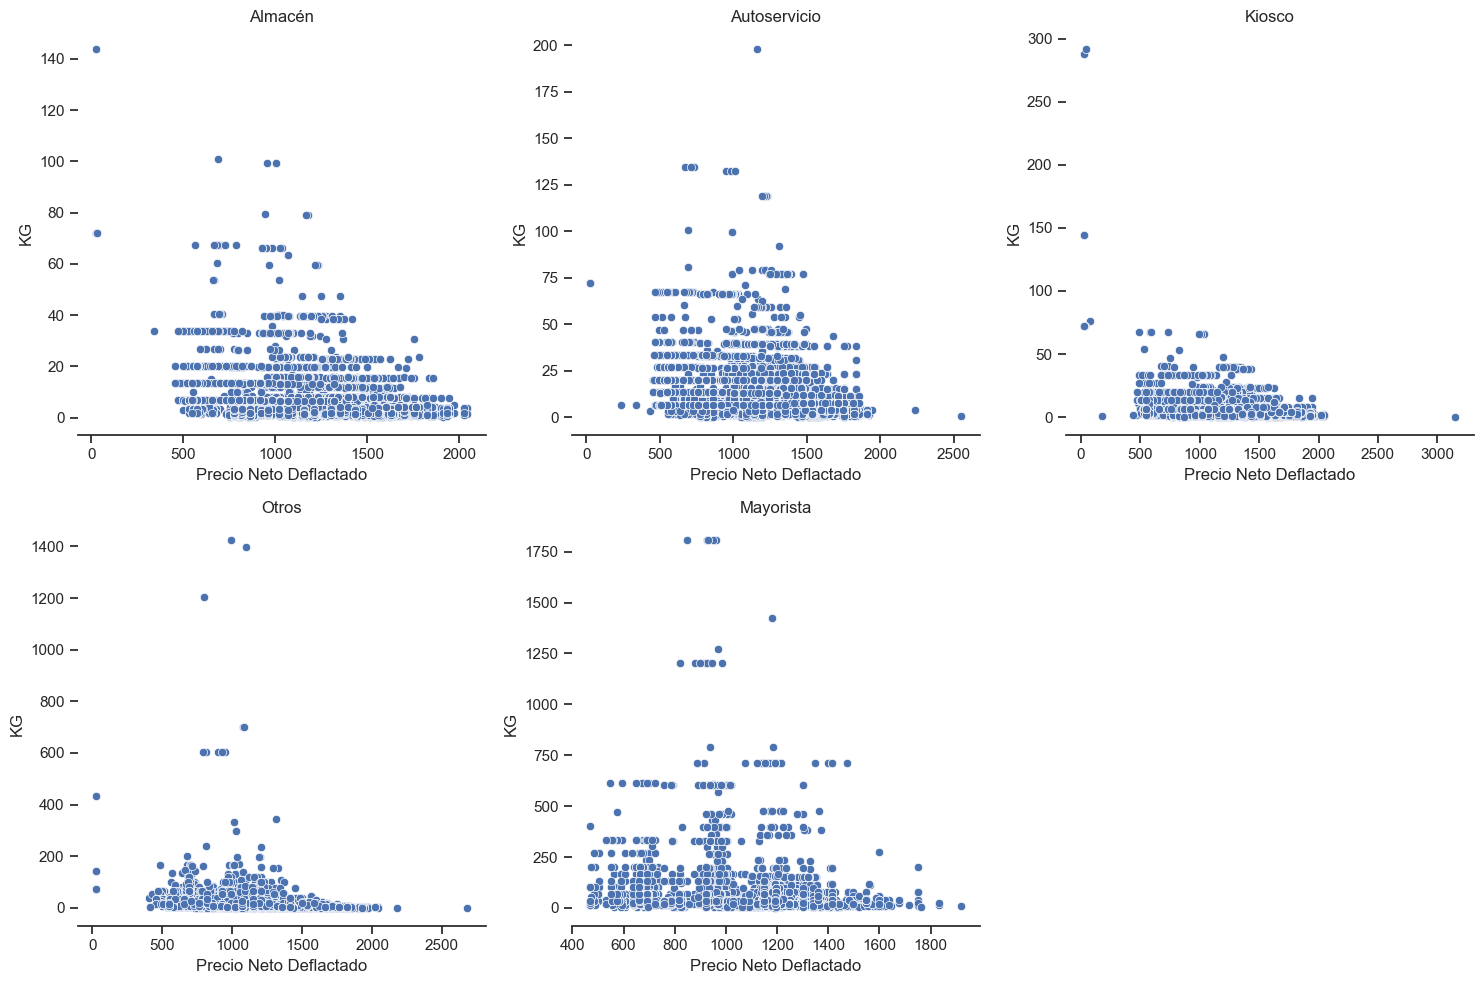

In [16]:
# Filtrar los canales que tienen datos
canales_con_datos = df2['Canal'].unique()

# Calcular el número total de subplots que se necesitarán
num_subplots = len(canales_con_datos)

# Calcular el número de filas y columnas
num_filas = (num_subplots - 1) // 3 + 1
num_columnas = min(num_subplots, 3)

# Crear una figura y ejes con el número correcto de filas y columnas
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(15, num_filas * 5))

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# Generar scatterplots por canal
for i, canal in enumerate(canales_con_datos):
    # Filtrar el DataFrame por canal
    datos_canal = df2[df2['Canal'] == canal]
    
    # Generar scatterplot para el canal actual
    sns.scatterplot(data=datos_canal, x="Precio Neto Deflactado", y="KG", ax=axs[i])
    axs[i].set_title(f'{canal}')
    axs[i].set_xlabel('Precio Neto Deflactado')
    axs[i].set_ylabel('KG')

# Ocultar el último subplot si no hay suficientes datos
if num_subplots < num_filas * num_columnas:
    fig.delaxes(axs[num_subplots])

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

    En principio, se observa una correlación negativa entre ambas variables, lo cual responde al concepto de elasticidad demanda-precio. Sin embargo, la presencia de outliers nos dificulta el análisis.
    Trataremos estos outliers mediante el método intercuartil, discriminado por Canal, en las variables KG y Precio.

In [160]:
# Definir el número de iteraciones
num_iteraciones = 5

# Definir la columna
col = 'KG'

# Definir parámetro IQR
par_IQR = 1.5

# Crear una copia de los datos originales
df3 = df2.copy()

# Iterar X veces para eliminar outliers
for _ in range(num_iteraciones):
    # Iterar sobre los valores únicos del campo 'Canal'
    for canal in df3['Canal'].unique():
        # Filtrar los datos para el canal actual
        datos_canal = df3[df3['Canal'] == canal]

        # Calcular el primer y tercer cuartil para la columna 'KG'
        Q1 = datos_canal[col].quantile(0.25)
        Q3 = datos_canal[col].quantile(0.75)

        # Calcular el rango intercuartílico (IQR)
        IQR = Q3 - Q1

        # Definir los límites superior e inferior
        lower_bound = Q1 - par_IQR * IQR
        upper_bound = Q3 + par_IQR * IQR

        # Eliminar los valores fuera del rango para el canal actual
        datos_canal = datos_canal[(datos_canal[col] < lower_bound) | (datos_canal[col] > upper_bound)]

        # Actualizar los datos en df3 eliminando los registros fuera del rango
        df3 = df3.drop(datos_canal.index)

# Reiniciar los índices del DataFrame resultante
df3.reset_index(drop=True, inplace=True)

print("Registros eliminados en esta iteración: ", df2.KG.size - df3.KG.size)
print("Porcentaje de registros eliminados: {:.1f}%".format(100*(df2.KG.size - df3.KG.size)/df3.KG.size))
print("Porcentaje de registros eliminados total: {:.1f}%".format(100*(df.KG.size - df3.KG.size)/df.KG.size))
print("Registros dataset original: ", df.KG.size)
print("Registros con outliers en total: ", df2.KG.size)
print("Registros sin outliers en total: ", df3.KG.size)

Registros eliminados en esta iteración:  7190
Porcentaje de registros eliminados: 7.8%
Porcentaje de registros eliminados total: 10.3%
Registros dataset original:  102457
Registros con outliers en total:  99076
Registros sin outliers en total:  91886


    La iteración corrida filtra los valores por la variable Canal, y elimina los valores de KG fuera del rango intercuartílico.
    Asumimos en este caso que la muestra resultante será representativa de la población. El algoritmo luego lo corremos varias veces para que vaya capturando la mayor cantidad de outliers.
    Como se observa arriba, la cantidad de registros que eliminó es de 7190.
    Corremos el mismo algoritmo para la variable Precio.

In [161]:
# Definir el número de iteraciones
num_iteraciones = 5

# Definir la columna
col = 'Precio Neto Deflactado'

# Definir parámetro IQR
par_IQR = 1.5

# Crear una copia de los datos originales
df4 = df3.copy()

# Iterar X veces para eliminar outliers
for _ in range(num_iteraciones):
    # Iterar sobre los valores únicos del campo 'Canal'
    for canal in df4['Canal'].unique():
        # Filtrar los datos para el canal actual
        datos_canal = df4[df4['Canal'] == canal]

        # Calcular el primer y tercer cuartil para la columna 'KG'
        Q1 = datos_canal[col].quantile(0.25)
        Q3 = datos_canal[col].quantile(0.75)

        # Calcular el rango intercuartílico (IQR)
        IQR = Q3 - Q1

        # Definir los límites superior e inferior
        lower_bound = Q1 - par_IQR * IQR
        upper_bound = Q3 + par_IQR * IQR

        # Eliminar los valores fuera del rango para el canal actual
        datos_canal = datos_canal[(datos_canal[col] < lower_bound) | (datos_canal[col] > upper_bound)]

        # Actualizar los datos en df3 eliminando los registros fuera del rango
        df4 = df4.drop(datos_canal.index)

# Reiniciar los índices del DataFrame resultante
df3.reset_index(drop=True, inplace=True)

print("Registros eliminados en esta iteración: ", df3.KG.size - df4.KG.size)
print("Porcentaje de registros eliminados: {:.1f}%".format(100*(df3.KG.size - df4.KG.size)/df4.KG.size))
print("Porcentaje de registros eliminados total: {:.1f}%".format(100*(df.KG.size - df4.KG.size)/df.KG.size))
print("Registros dataset original: ", df.KG.size)
print("Registros con outliers en total: ", df2.KG.size)
print("Registros sin outliers en total: ", df4.KG.size)

Registros eliminados en esta iteración:  16
Porcentaje de registros eliminados: 0.0%
Porcentaje de registros eliminados total: 10.3%
Registros dataset original:  102457
Registros con outliers en total:  99076
Registros sin outliers en total:  91870


    Como se observa, el dataset resultante del algoritmo anterior nos dejó con pocos outliers para la variable precio, la cual al correr el mismo algortimo sólo eliminó 16 outliers.
    Actualizamos los gráficos para analizar la distribución resultante.

    Boxplot de los datos cerrados (sin segregación por Canal)

C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


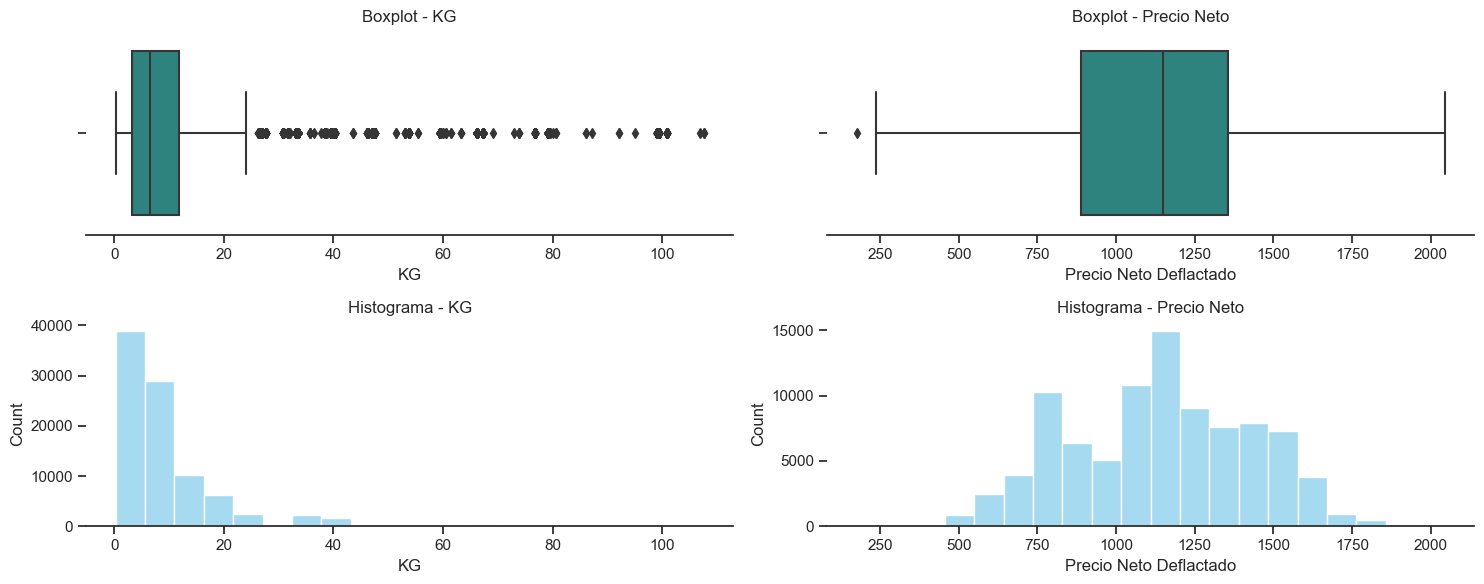

In [144]:
# Crear una figura y ejes compartidos
fig, axs = plt.subplots(2, 2, figsize=(15, 6))

# Boxplot para Campo1
sns.boxplot(x=df4['KG'], ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title('Boxplot - KG')

# Boxplot para Campo2
sns.boxplot(x=df4['Precio Neto Deflactado'], ax=axs[0, 1], palette='viridis')
axs[0, 1].set_title('Boxplot - Precio Neto')

# Histograma para Campo1
sns.histplot(x=df4['KG'], ax=axs[1, 0], color='skyblue', bins = 20)
axs[1, 0].set_title('Histograma - KG')

# Histograma para Campo2
sns.histplot(x=df4['Precio Neto Deflactado'], ax=axs[1, 1], color='skyblue', bins = 20)
axs[1, 1].set_title('Histograma - Precio Neto')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

    Los datos previo a la apertura por Canal muestran una distribución más clara.

C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\easue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

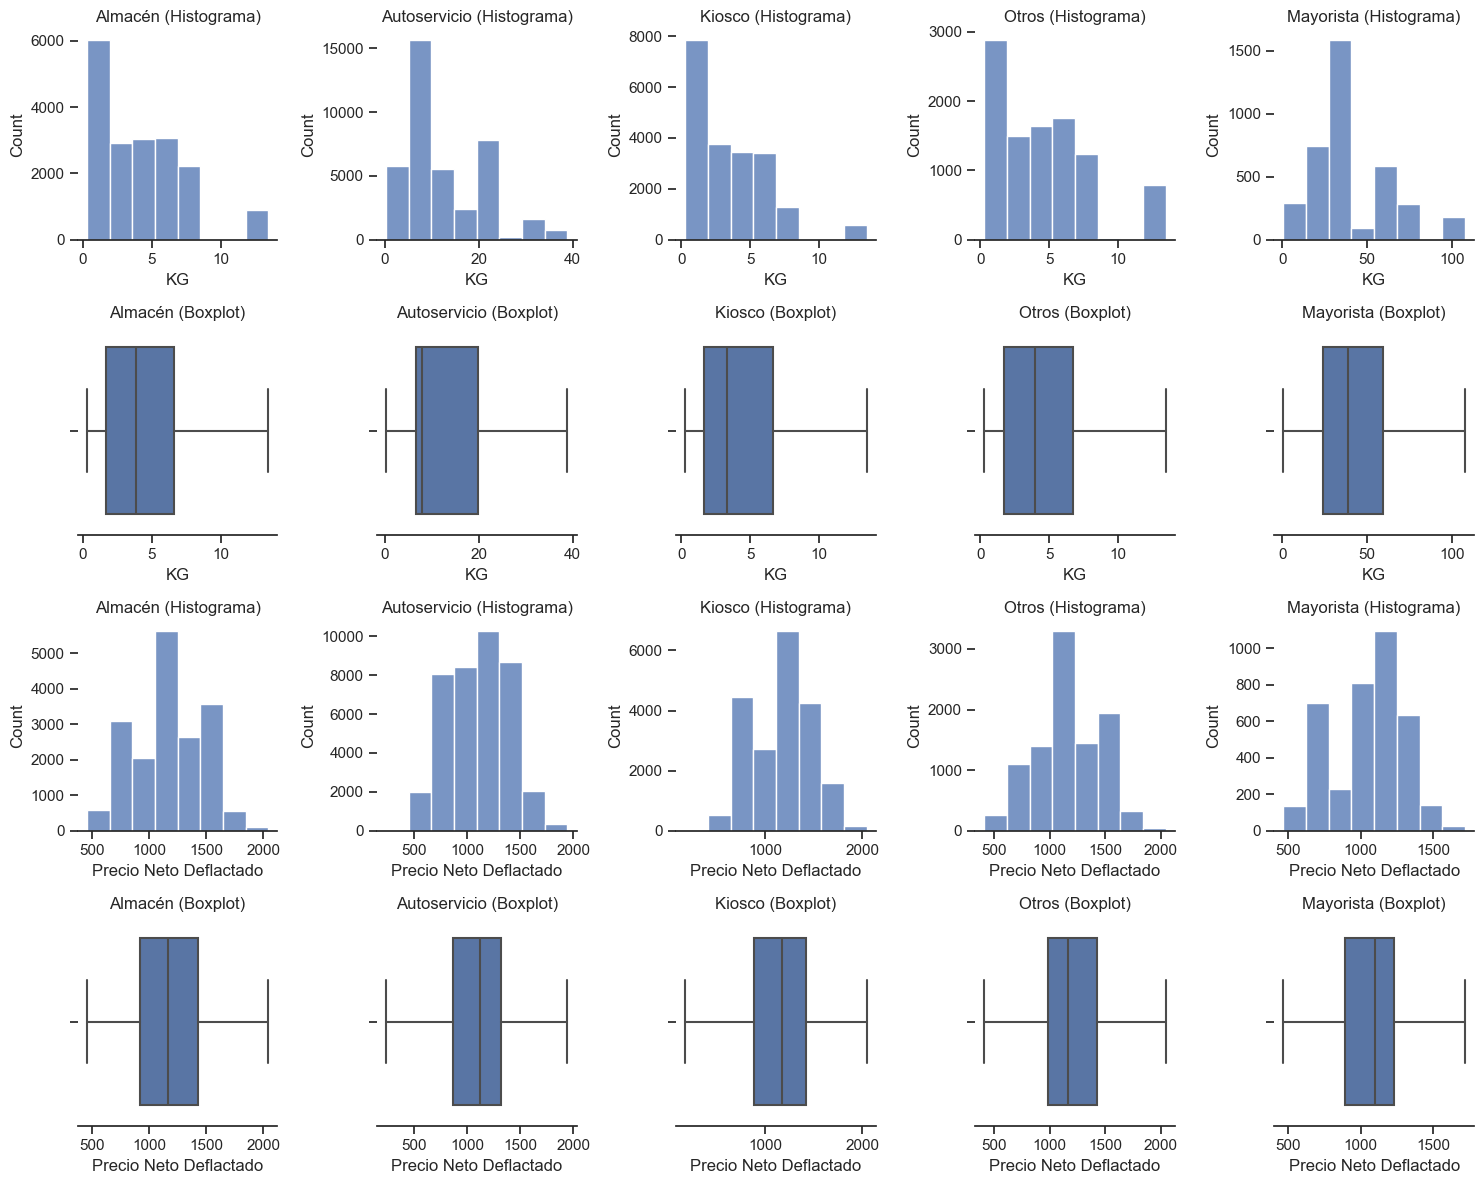

In [150]:
# Crear una figura y ejes con 2 filas y 5 columnas
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharey=False)

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# Generar histogramas por canal
for i, canal in enumerate(df2['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df4[df4['Canal'] == canal]
    
    # Generar histograma para el canal actual
    sns.histplot(data=datos_canal, x="KG", ax=axs[i], bins=8)  # Ajusta bins según tus necesidades
    axs[i].set_title(f'{canal} (Histograma)')

# Generar 5 boxplots adicionales
for i, canal in enumerate(df4['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df4[df4['Canal'] == canal]
    
    # Generar boxplot para el canal actual
    sns.boxplot(data=datos_canal, x="KG", ax=axs[i + 5])
    axs[i + 5].set_title(f'{canal} (Boxplot)')    

# Generar histogramas por canal
for i, canal in enumerate(df4['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df4[df4['Canal'] == canal]
    
    # Generar histograma para el canal actual
    sns.histplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 10], bins=8)  # Ajusta bins según tus necesidades
    axs[i + 10].set_title(f'{canal} (Histograma)')

# Generar 5 boxplots adicionales
for i, canal in enumerate(df4['Canal'].unique()):
    # Filtrar el DataFrame por canal
    datos_canal = df4[df4['Canal'] == canal]
    
    # Generar boxplot para el canal actual
    sns.boxplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 15])
    axs[i + 15].set_title(f'{canal} (Boxplot)')    
    
# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

    Aperturando por Canal... [seguir]

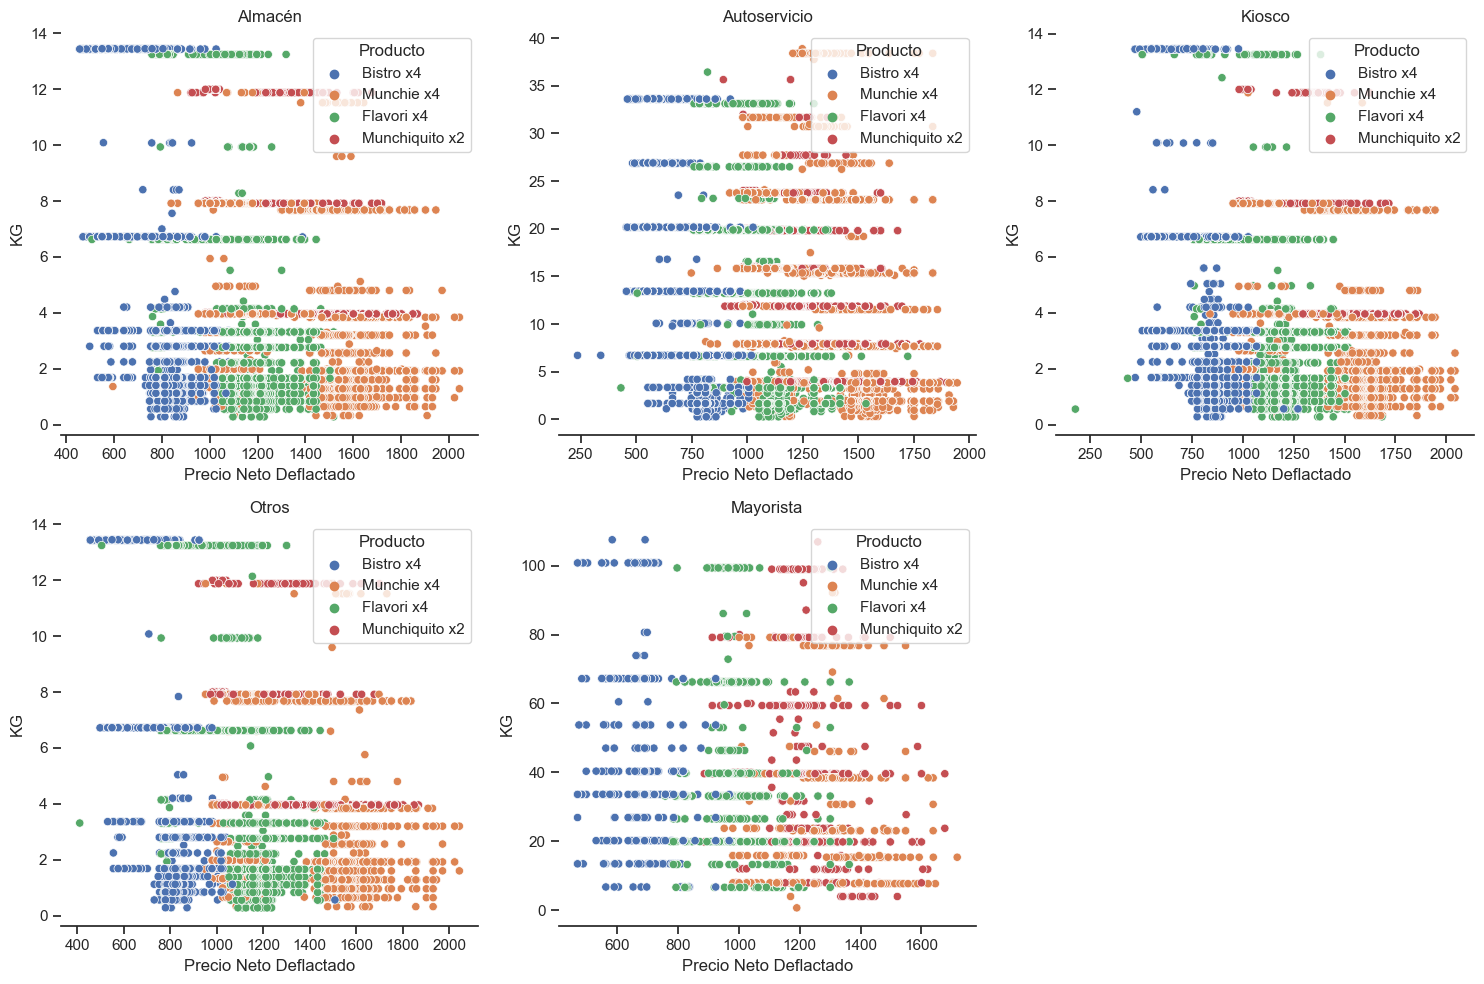

In [154]:
# Filtrar los canales que tienen datos
canales_con_datos = df4['Canal'].unique()

# Calcular el número total de subplots que se necesitarán
num_subplots = len(canales_con_datos)

# Calcular el número de filas y columnas
num_filas = (num_subplots - 1) // 3 + 1
num_columnas = min(num_subplots, 3)

# Crear una figura y ejes con el número correcto de filas y columnas
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(15, num_filas * 5))

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# Generar scatterplots por canal
for i, canal in enumerate(canales_con_datos):
    # Filtrar el DataFrame por canal
    datos_canal = df4[df4['Canal'] == canal]
    
    # Generar scatterplot para el canal actual
    sns.scatterplot(data=datos_canal, x="Precio Neto Deflactado", y="KG", ax=axs[i], hue = "Producto")
    axs[i].set_title(f'{canal}')
    axs[i].set_xlabel('Precio Neto Deflactado')
    axs[i].set_ylabel('KG')

# Ocultar el último subplot si no hay suficientes datos
if num_subplots < num_filas * num_columnas:
    fig.delaxes(axs[num_subplots])

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

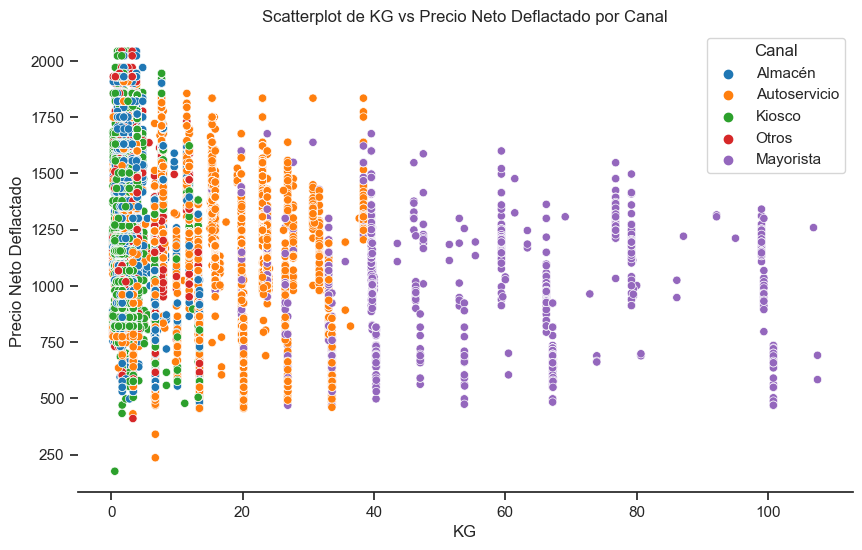

In [153]:
# Crear el scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df4, x='KG', y='Precio Neto Deflactado', hue='Canal', palette='tab10')

# Añadir título y etiquetas de los ejes
plt.title('Scatterplot de KG vs Precio Neto Deflactado por Canal')
plt.xlabel('KG')
plt.ylabel('Precio Neto Deflactado')

# Mostrar la leyenda
plt.legend(title='Canal')

# Mostrar el gráfico
plt.show()